# Data Mining: Stat. Modeling & Learning from Data


## Determine the gender of Reddit authors using their comments 

(https://www.kaggle.com/c/datamining2020/overview/evaluation)

*Reddit is an entertainment, social networking, and news website where registered community members can submit content, such as text posts or direct links, making it essentially an online bulletin board system. Registered users can then vote submissions up or down to organize the posts and determine their position on the site's pages. Content entries are organized by areas of interest called "subreddits". The subreddit topics include news, gaming, movies, music, books, fitness, food, and photosharing, among many others.*

*The Reddit website has an API and its code is open source. In July 2015, a Reddit user identified as Stuck_In_the_Matrix made public a dataset of Reddit comments for research. The dataset has approximately 1.7 billion comments and takes 250 GB compressed. Each entry contains comment, score, author, subreddit, position in comment tree and other fields that are available through Reddit's API.*

One of the user attributes that is not natively supported by the Reddit platform is the gender. However, in some subreddits, users can self report their genders as part of the subreddit rules. In the scope of this competition, users that self reported their gender are selected from the dataset, and **your goal is to predict the gender of these users**.

The **evaluation metric for this competition is the Area Under the ROC Curve**. This metric is used to evaluate binary classification, and in the scope of this competition we are representing the gender of the users as binary classes: the class "female" is represented as 1 and the class "male" as 0. The class prediction for each Reddit author corresponds to your confidence that the author is a female, which is a "score" computed for the author (e.g. estimated probability in logistic regression).

*Submission Format:*
 For every author in the dataset, submission files should contain two columns: author and gender. The column author should be a string. The column gender can be any real value. The higher is your confidence that the author is female, the higher should be the corresponding value in the gender column.

The notebook is composed by five parts:

- Load data and EDA
- Preprocessing
- Feature matrix creation (with doc2vec, tdidf, sparse matrix)
- Training and evaluation for model selecion
- Retrain over the whole dataset + prepare the solution

# 1. Dataset preparation

In [1]:
#import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import string

In [2]:
#load the data as pandas dataframe

train_data = pd.read_csv('train_data.csv')
train_target = pd.read_csv ('train_target.csv')
test_data = pd.read_csv ('test_data.csv')

In [3]:
#take a look at our training dataset and target

print(np.shape(train_data))
train_data.head()

(296042, 4)


,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [4]:
print(np.shape(train_target))
train_target.head()

(5000, 2)


,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


As we can see, we have binary target: 0 and 1 represents the gender (0 for male and 1 for female).

Binary target  >>>  Binary classification

In [19]:
#target vector
y = train_target.gender

y = np.array(list(map(np.array, y)))

In [5]:
#let's organize our data
#lists of authors divided by gender 

author0=[]
author1=[]
for i in range(len(train_target['author'])):
    if train_target['gender'][i]==0:
        author0.append(train_target['author'][i])
    else:
        author1.append(train_target['author'][i]) 

In [6]:
#target column: for each author name, we associate the gender IN ORDER

gender=[]
for i in range(np.shape(train_data)[0]):
    if train_data['author'][i] in author0:
        gender.append(0)
    elif train_data['author'][i] in author1:
                gender.append(1)

In [7]:
#dataset that shows the useful informations
#author, subreddit, text, gender

train_df = pd.DataFrame({'author': train_data['author'],
                   'subreddit': train_data['subreddit'],
                   'text': train_data['body'],
                   'gender': gender
                    })
train_df.set_index('author')

,subreddit,text,gender
author,,,
Shamus_Aran,mylittlepony,I don't think we'd get nearly as much fanficti...,0
Riddance,sex,"Thanks. I made it up, that's how I got over my...",1
Secret_Wizard,DragonsDogma,Are you sure you aren't confusing Cyclops (the...,0
Penultimatum,malefashionadvice,dont do this to me bro,0
7-SE7EN-7,todayilearned,That's what we do when we can't find a mate,0
...,...,...,...
Tashre,FiftyFifty,I don't want to play this game anymore :(,0
someguyfromtheuk,AskReddit,Twist: I am your son and staged all of this to...,0
spurscanada,HIMYM,I think a lot of people don't like her because...,0


In [8]:
#the same for the test set

n=[]
for i in range(len(test_data['body'])):
    n.append('?')
    
train_df2 = pd.DataFrame({'author': test_data['author'],
                   'subreddit': test_data['subreddit'],
                   'text': test_data['body'],
                   'gender': n
                    })

train_df2.set_index('author')

,subreddit,text,gender
author,,,
ejchristian86,TwoXChromosomes,I hadn't ever heard of them before joining thi...,?
ZenDragon,gaming,"At 7680 by 4320 with 64x AA, right?",?
savoytruffle,AskReddit,bite me,?
hentercenter,stlouisblues,Damn that was a good penalty :(,?
rick-o-suave,army,I swore into DEP on 6-OCT and I left 5-NOV und...,?
...,...,...,...
friedeggzohyeah,TrollXChromosomes,Oh god I my mom has celiac and has to buy insa...,?
im_a_leadfarmer,psychology,"Great, I guess i won't skip my 4th one at work...",?
misandrical_unicorn,atheism,[k](http://gifrific.com/wp-content/uploads/201...,?


### A quick exploratory data analysis

In [9]:
train_df.info()  #No variable column has null/missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296042 entries, 0 to 296041
Data columns (total 4 columns):
author       296042 non-null object
subreddit    296042 non-null object
text         296042 non-null object
gender       296042 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.0+ MB


In [10]:
train_df.describe()  #dataset is not calibrate (look at the mean)

,gender
count,296042.000000
mean,0.227620
std,0.419297
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [11]:
train_df.gender.value_counts()  #not bilanced: augmentation can be a solution (not implemented in this notebook)

0    228657
1     67385
Name: gender, dtype: int64

# 2. Preprocessing

In [13]:
#import the necessary libraries

from nltk.stem import SnowballStemmer
import re
from nltk.corpus import stopwords

### 1) Group by author + mantain the same order of train target

In [14]:
#mantain the same order of train_target.author

sort=[]
for author in train_target.author:
    sort.append(author)

In [15]:
#group by author the sentences

T=train_df.groupby('author').text.apply(list).reset_index()

In [16]:
#same order than 'sort'

t=[]
for i in range(len(sort)):
    for j in range(len(T['author'])):
        if sort[i]==T['author'][j]:
            s=str(T['text'][j])
            s = re.sub(r'[^\w\s]','',s)   #union of the sentences of a single author
            t.append(s)      

In [17]:
#new useful dataset: we have the sentences grouped by author

DF = pd.DataFrame({'author': sort,
                   'text': t,
                   'gender': y 
                  })
DF.set_index('author')

,text,gender
author,,
RedThunder90,I still prefer to buy foods either grown local...,0
Lirkmor,A name friend Ten points to Gryffindor Hyperbo...,1
In0chi,Do you even read what he wrote 250 Stacks 750...,0
ProjectGrudge,In all fairness regardless of its demonic infl...,0
TehTurtleHermit,Darn someone already used it Yep a coworker s...,0
...,...,...
AdamDe27,I dont think its shopped e1httpcs411029userapi...,0
sissy_space_yak,Psst Im pretty sure uway_fairer is a chick As ...,1
lilgump,They usually dont have to be very good because...,0


In [18]:
#the same for test dataset
#mantain the same order of train_target.author 

sort2=[]
for author in test_data.author.unique():    #(unique() for counting one time each author)
    sort2.append(author)

In [20]:
T2=train_df2.groupby('author').text.apply(list).reset_index()

In [21]:
t2=[]
for i in range(len(sort2)):
    for j in range(len(T2['author'])):
        if sort2[i]==T2['author'][j]:
            s=str(T2['text'][j])
            s = re.sub(r'[^\w\s]','',s)   #union of the sentences of a single author
            t2.append(s)

In [22]:
DF_2 = pd.DataFrame({'author': sort2,
                   'text': t2
                    })

In [23]:
DF.to_csv(r'DF.csv', index = False)
#DF = pd.read_csv('DF.csv')

DF_2.to_csv(r'DF_2.csv', index = False)
#DF_2 = pd.read_csv('DF_2.csv')

### 2) Clean text (this preprocessing step is for doc2vec)

In [24]:
#this function can clean the text, passed as input (remove punctuation, numbers, stop words...)

def clean_text(text):
 
    #Lower case
    lower = text.apply(str.lower)
    
    #Removing HTML tags
    rem_html = lower.apply(lambda x: x.replace('#39;', "'").replace('amp;', '&')
                             .replace('#146;', "'").replace('nbsp;', ' ').replace('#36;', '$')
                             .replace('\\n', "\n").replace('quot;', "'").replace('<br />', " ")
                             .replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.')
                             .replace(' @-@ ','-').replace('\\', ' \\ ').replace('&lt;','<')
                             .replace('&gt;', '>'))
    
    #Stemming: reducing different forms of a word to a core root (for example: reduce 'sleeping' to 'sleep')
    stem = SnowballStemmer('english')
    stemmed = rem_html.apply(lambda x: ' '.join(stem.stem(word) for word in str(x).split()))
    
    #removing punctuation
    rem_punc = stemmed.apply(lambda x: re.sub(r'[^\w\s]',' ',x).replace('_',' '))
    
    #removing stopwords and extra spaces
    stop_words = set(stopwords.words('english'))
    rem_stopwords = rem_punc.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
    
    #removing numbers
    rem_num = rem_stopwords.apply(lambda x: " ".join(x for x in x.split() if not x.isdigit()))
    
    #remove words having length=1
    rem_lngth1 = rem_num.apply(lambda x: re.sub(r'\b\w{1}\b',' ',x))

    
    return rem_lngth1

In [25]:
#apply our function to the sentences

preproc_text=clean_text(DF['text'])

In [26]:
#dataset renovation to check out the results

DF2 = pd.DataFrame({'author': sort,
                    'text': t,
                   'clean_text': preproc_text,
                   'gender': y
                    })
DF2.set_index('author')

,text,clean_text,gender
author,,,
RedThunder90,I still prefer to buy foods either grown local...,still prefer buy food either grown local anim ...,0
Lirkmor,A name friend Ten points to Gryffindor Hyperbo...,name friend ten point gryffindor hyperbol half...,1
In0chi,Do you even read what he wrote 250 Stacks 750...,even read wrote stack damag dont think youd da...,0
ProjectGrudge,In all fairness regardless of its demonic infl...,fair regardless demon influenc zumba high susp...,0
TehTurtleHermit,Darn someone already used it Yep a coworker s...,darn someon alreadi use yep cowork show soon m...,0
...,...,...,...
AdamDe27,I dont think its shopped e1httpcs411029userapi...,dont think shop e1httpcs411029userapicomv41102...,0
sissy_space_yak,Psst Im pretty sure uway_fairer is a chick As ...,psst im pretti sure uway fair chick woman whos...,1
lilgump,They usually dont have to be very good because...,usual dont veri good becaus front fee much pre...,0


In [27]:
#apply our function to the test sentences
preproc_text2=clean_text(DF_2['text'])

In [28]:
DF2_2 = pd.DataFrame({'author': sort2,
                    'text': t2,
                    'clean_text': preproc_text2
                    })

# 3. Features creation

### 3.1 Doc2Vec

Doc2Vec is a unsupervised tecnique that creates a numeric representation of text documents: it can associate each sentence to a numeric vector, that represents the sentence itself in a n-dimensional space.

It works in order to research relations between words and try to quantify this relations in a numeric way (it is based on Word2Vec, a method of word embedding that transform words in vectors)

Similar messages will be close in the space.

I will use this model on the whole sentences (training + test), but the ML algorithm will use only the training vectors.

In [29]:
from gensim.models import doc2vec
from collections import namedtuple

In [30]:
doc1=list(DF2['clean_text'])   #the preprocessed test

In [31]:
doc2=list(DF2_2['clean_text'])  #for the test

In [32]:
# Transform data and prepare it for the algorithm Doc2Vec

docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(doc1):
    words = str(text).lower().split()
    tags = [i]
    docs.append(analyzedDocument(words, tags))

In [33]:
#(same for test)

docs2 = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(doc2):
    words = str(text).lower().split()
    tags = [i]
    docs2.append(analyzedDocument(words, tags))

In [34]:
# Train model

# Parameters meaning: doc2vec.Doc2Vec(sentences to vectorize, size = size of the feature vectors, 
#                                      window = maximum distance between the current and predicted word within a sentence, 
#                                      min_count = words with total frequency lower than this will be ignored, 
#                                      workers = number of worker threads used to train the model, epochs=number of training iteration)  

model = doc2vec.Doc2Vec(docs+docs2, size = 100, window = 1, min_count = 3, workers = 6, epochs=10)  

C:\Users\arian\anaconda\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [35]:
#the final training set is a set of vectors
#each vector represents a sentence or a union of sentences; one vector for each author
v=[]
for i in range(len(docs)):
    v.append(model.docvecs[i])
len(v)==len(y)   #y is the label vector 

True

In [36]:
#test
v2=[]
for i in range(len(docs2)):                     
    v2.append(model.docvecs[i])   #v2.append(model.docvecs[-i])  
#v2[::-1]           #reverse


In [37]:
#normalization
from sklearn.preprocessing import normalize
wnorm=v+v2
wnorm=np.array(wnorm)
wnorm=normalize(wnorm)

In [38]:
#create the features matrix (v and v2 are lists) + normalization
X_d2v=wnorm[:len(docs)]
X_d2v_test=wnorm[len(docs):]

In [39]:
#The size of the array is [n_samples, n_features]
np.shape(X_d2v), np.shape(X_d2v_test)

((5000, 100), (15000, 100))

### 3.2 sparse matrix gender vs subreddit

In [40]:
from scipy import sparse

In [41]:
#training set
subreddits = train_data.subreddit.unique()
subreddits_map = pd.Series(index=subreddits, data=np.arange(subreddits.shape[0]))

#validation test
subreddits2 = test_data.subreddit.unique()
subreddits_map2 = pd.Series(index=subreddits2, data=np.arange(subreddits2.shape[0]))

In [42]:
def extract_features(group):
    group_subreddits = group['subreddit'].values       #subreddit names
    idxs = subreddits_map[group_subreddits].values
    v = sparse.dok_matrix((1, subreddits.shape[0]))    #sparse matrix (1xsubreddit dim)
    for idx in idxs:
        if not np.isnan(idx):
            v[0, idx] = 1                              #where to put 1 in the sparse matrix
    return v.tocsr()                                   #Compressed Sparse Row matrix format

In [43]:
features_dict = {}           #features dictionary

for author, group in train_data.groupby('author'):
    features_dict[author] = extract_features(group)

In [44]:
features_dict2 = {}          #for the test set

for author, group in test_data.groupby('author'):
    features_dict2[author] = extract_features(group)

In [45]:
#feature matrix (sparse) with the features vectors as columns

SP = sparse.vstack([features_dict[author] for author in train_target.author])

In [46]:
SP2 = sparse.vstack([features_dict2[author] for author in test_data.author.unique()])

### 3.3 TDFIDF (term frequency–inverse document frequency)
How important is a word in a document? Term frequency–inverse document frequency compute the "importance of a word", in term of its weight in the document.

**tfidf = term frequency * inverse document frequency**

term frequency = number of times that a word occur in a document

inverse document frequency = log(number of documents/number of document containing the term

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

CV=CountVectorizer(max_df=0.90, min_df= 3, stop_words= 'english' , ngram_range = (1,2), max_features=20000) 
#preprocessing step:
    #ngram_range = (1,2): unigrams and bigrams
    #max_df, min_df: ignore word with frequency greater/less
 
e=list(DF2['text'])+list(DF2_2['text'])    #training + set

X = CV.fit_transform(e)       #fit CV on the whole set of sentences

tfidf = TfidfTransformer()

sparse = tfidf.fit_transform(X)    #TFIDF feature matrix creation

np.shape(sparse)      #a sparse matrix is a matrix with big dimension and many zeros (we have many and many different words..
                       #and many of this appear in only a few sentences)

(20000, 20000)

In [48]:
ss=sparse[:5000]   #train feature matrix
ss2=sparse[5000:]  #test feature matrix
ss = ss.toarray()
ss2 = ss2.toarray()

np.shape(ss), np.shape(ss2)

((5000, 20000), (15000, 20000))

# 4. Model selection

I have tried different models. I don’t report all the implementations because in all cases I have obtained a validation score that is less that the one I have obtain with MLPClassifier, the model I have decided to use. MLPClassifier perfoms better on doc2vec, sparse matrix gender-subreddit and tfidf.

(Models I have tested with the validation set are: naive_bayes, svm.svc, svm.nusvc)

In [75]:
from sklearn import model_selection
from sklearn import preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition, ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [69]:
from sklearn.metrics import make_scorer
score=make_scorer(roc_auc_score)

### 4.1 doc2vec: MLP performs better

In [142]:
#training-validation split of the dataset and the target
#for the three models I have choose the same seed and the same test size, in order to put the results togheter then

SEED = 2000
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X_d2v, y, test_size = 1000, random_state = SEED)

In [143]:
#gridsearch for hyperparameters selection
   
a=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 0.5, 0.005, 0.0005]
    
grid = GridSearchCV(estimator=MLPClassifier(),
                    param_grid={'activation':('identity', 'logistic', 'tanh', 'relu'),  
                         'solver':('lbfgs', 'sgd', 'adam'),
                         'alpha': a,
                         'learning_rate': ('constant', 'adaptive', 'invscaling')},
                     scoring=score)                                                         

In [144]:
grid.fit(X_d2v, y)

C:\Users\arian\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'activation': ('identity', 'logistic', 'tanh', 'relu'),
                         'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 0.5,
                                   0.005, 0.0005],
                  

In [145]:
print("Best parameter choice:", grid.best_params_)  #{'activation': 'identity', 'alpha': 0.0005, 'learning_rate': 'adaptive', 'solver': 'sgd'}

Best parameter choice: {'activation': 'logistic', 'alpha': 0.005, 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


In [194]:
MLP=MLPClassifier(activation='logistic', alpha=0.005, learning_rate='adaptive', max_iter=200, solver='lbfgs').fit(train_x, train_y) 

In [195]:
predMLP=MLP.predict_proba(valid_x)     #Returns T array-like of shape (n_samples, n_classes) : 
                                       #the probability of the items of the sample to belong to one of the two classes

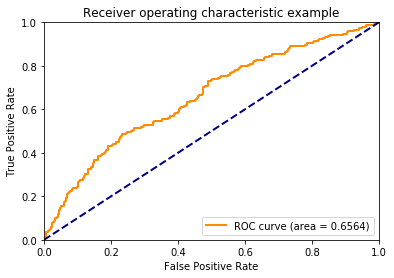

In [196]:
#Roc Curve for validation data (Receiver operating characteristic) and AUC (area under the curve)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(valid_y, predMLP[:,1])
roc_auc = auc(fpr, tpr) 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 4.2 sparse matrix gender vs subreddit: MLP

In [54]:
SEED = 2000
train_xs, valid_xs, train_ys, valid_ys = model_selection.train_test_split(SP, y, test_size = 1000, random_state = SEED)

In [216]:
#gridsearch for optimum hyperparameters

grid = GridSearchCV(estimator=MLPClassifier(),
                    param_grid={'activation':('identity', 'logistic', 'tanh', 'relu'),  
                         'solver':('lbfgs', 'sgd', 'adam'),
                         'alpha': a,
                         'learning_rate': ('constant', 'adaptive', 'invscaling')},
                    scoring=score) 


In [ ]:
grid.fit(SP, y)

C:\Users\arian\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
print ("best parameter choice:", grid.best_params_)

In [55]:
MLPSparse=MLPClassifier(solver = 'adam', activation= 'relu' ,alpha = 0.015,
                         learning_rate = 'invscaling', max_iter = 400).fit(train_xs, train_ys)

In [56]:
predMLPSparse=MLPSparse.predict_proba(valid_xs)   #probability prediction

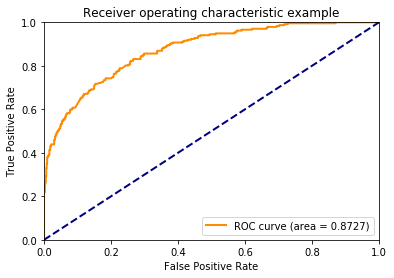

In [57]:
# Roc Curve for validation data 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(valid_ys, predMLPSparse[:,1])
roc_auc = auc(fpr, tpr) 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 4.3 Tfidf: MLP

In [58]:
SEED = 2000
train_xt, valid_xt, train_yt, valid_yt = model_selection.train_test_split(ss, y, test_size = 1000, random_state = SEED)

In [ ]:
#gridsearch for optimum hyperparameters

grid = GridSearchCV(estimator=MLPClassifier(),
                    param_grid={'activation':('identity', 'logistic', 'tanh', 'relu'),  
                         'solver':('lbfgs', 'sgd', 'adam'), 
                         'alpha': a,
                         'learning_rate': ('constant', 'adaptive', 'invscaling')},
                    scoring=score)

In [ ]:
grid.fit(ss, y)

In [ ]:
print ("best parameter choice:", grid.best_params_)  

In [60]:
MLP_t = MLPClassifier(activation= 'logistic', solver = 'adam', alpha = 0.015, verbose = False, early_stopping = True,
                         learning_rate = 'invscaling', max_iter = 400).fit(train_xt, train_yt) 

In [61]:
predMLP_t=MLP_t.predict_proba(valid_xt) 

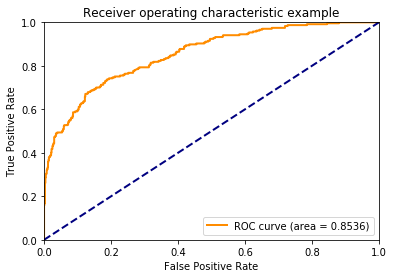

In [62]:
# Roc Curve for validation data 
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(valid_yt, predMLP_t[:,1])
roc_auc = auc(fpr, tpr) 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 4.4 Put togheter the results: logistic regression¶
I create a new set of training vectors, 3 dimensional (each vec has three coordinates: the predictions of the three model I have implemented,mlp with doc2vec, tfidf, the sparse matrix gender-subreddit)

In [197]:
#components of the new vectors: the predictions (prob to be female)
a=np.transpose(predMLP)[1]
b=np.transpose(predMLPSparse)[1]
c=np.transpose(predMLP_t)[1]

In [198]:
#dataframe
Final = pd.DataFrame({"y_validation": valid_y, "predMLP": a, "predMLPSparse": b, 'predMLP_t':c}) 

In [199]:
#feature matrix and target
Xf = Final.iloc[:, 1:4]
yf = Final.y_validation

In [200]:
#split train-valid
SEED = 1000
x_trainLR , x_validationLR, y_trainLR , y_validationLR = model_selection.train_test_split(Xf, yf, test_size = 0.2, 
                                                                                              random_state = SEED)

In [201]:
#gridsearch for hyperparameters selection
GSL=GridSearchCV(estimator=linear_model.LogisticRegression(),
                 param_grid={'multi_class':('auto', 'ovr', 'multinomial'), 'C': (0.001,0.1,0.01,0.8,0.9,1,1.1,1.2,2,10), 
                         'max_iter': (100,200,300,400), 'solver': ('newton-cg', 'lbfgs', 'sag', 'saga')},
                 scoring=score)

In [202]:
GSL=GSL.fit(Xf, yf)

C:\Users\arian\anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [203]:
print ("best parameter choice:", GSL.best_params_)  

best parameter choice: {'C': 10, 'max_iter': 100, 'multi_class': 'auto', 'solver': 'newton-cg'}


In [204]:
lrClf = LogisticRegression(C= 10, max_iter= 100, multi_class= 'multinomial', solver= 'newton-cg').fit(x_trainLR, y_trainLR)

In [205]:
predlrClf=lrClf.predict_proba(x_validationLR) 

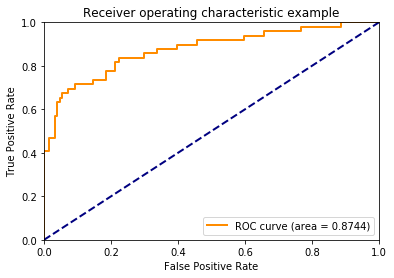

In [206]:
# Roc Curve for validation data  
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_validationLR, predlrClf[:,1])
roc_auc = auc(fpr, tpr) 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 5. Prepare the solution

Retrain the three model over the whole training set and predict the probability for the test set. Finally, use logistic regression over this probability and return the final prediction

In [208]:
MLP2=MLPClassifier(activation='logistic', alpha=0.005, learning_rate='adaptive', max_iter=200, solver='lbfgs').fit(X_d2v, y) 
predMLP2=MLP2.predict_proba(X_d2v_test) 

In [132]:
MLPSparse2=MLPClassifier(solver = 'adam', activation= 'relu' ,alpha = 0.015,
                         learning_rate = 'invscaling', max_iter = 400).fit(SP, y)  
predMLPSparse2=MLPSparse.predict_proba(SP2) 

In [133]:
MLP_t2 = MLPClassifier(solver = 'adam', activation= 'logistic' ,alpha = 0.001,
                         learning_rate = 'invscaling', max_iter = 400).fit(ss, y) 
predMLP_t2=MLP_t2.predict_proba(ss2) 

In [209]:
a2=np.transpose(predMLP2)[1]
b2=np.transpose(predMLPSparse2)[1]
c2=np.transpose(predMLP_t2)[1]

In [210]:
Final2 = pd.DataFrame({"predMLP2": a2, "predMLPSparse2": b2, 'predMLP_t2':c2})
Xf2 = Final2.iloc[:, 0:3]

In [211]:
lrClf2 = LogisticRegression(C= 10, max_iter= 100, multi_class = 'multinomial', solver = 'newton-cg').fit(Xf, yf) 

In [212]:
prob=lrClf2.predict_proba(Xf2)[:,1]

In [213]:
submission = pd.DataFrame({"author":test_data.author.unique(), "gender":prob})

In [214]:
submission.to_csv("submission.csv", index=False)

In [215]:
submission.head()

,author,gender
0,ejchristian86,0.992388
1,ZenDragon,0.020043
2,savoytruffle,0.017620
3,hentercenter,0.018778
4,rick-o-suave,0.084776
